# Using Scattertext and AgeFromName to find gender-discriminating terms

https://github.com/JasonKessler/scattertext

https://github.com/JasonKessler/agefromname

Cite as:
Jason S. Kessler. Scattertext: a Browser-Based Tool for Visualizing how Corpora Differ. Proceedings of the 54th Annual Meeting of the Association for Computational Linguistics (ACL): System Demonstrations. 2017.

Link to preprint: https://arxiv.org/abs/1703.00565

`
@article{kessler2017scattertext,
  author    = {Kessler, Jason S.},
  title     = {Scattertext: a Browser-Based Tool for Visualizing how Corpora Differ},
  booktitle = {ACL System Demonstrations},
  year      = {2017},
}
`

In [1]:
%matplotlib inline
import scattertext as st
import re, io, itertools
from pprint import pprint
import pandas as pd
import numpy as np
import spacy.en
import os, pkgutil, json, urllib
from urllib.request import urlopen
from IPython.display import IFrame
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

In [2]:
nlp = spacy.en.English()
# If this doesn't work, please uncomment the following line and use a regex-based parser instead
#nlp = st.whitespace_nlp_with_sentences

In [3]:
convention_df = st.SampleCorpora.ConventionData2012.get_data()
convention_df['parsed'] = convention_df.text.apply(nlp)

## The `agefromname` package takes 
### - a first name,
### - optional: a minimum age,
### - optional: current year
## and returns
### - the probablity someone is male or female
### `pip install agefromname`

In [4]:
from agefromname import AgeFromName

In [5]:
gender_imputer = AgeFromName()

In [6]:
gender_imputer.prob_male('kelsey')

0.03137094193268891

In [7]:
gender_imputer.prob_male('kelsey', minimum_age=70)

0.833774227446812

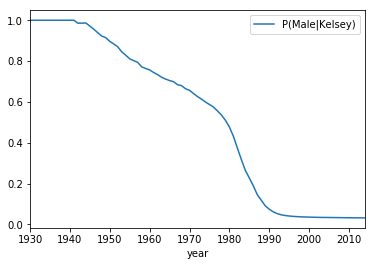

In [8]:
(pd.DataFrame([{'year': year, 
                'P(Male|Kelsey)': gender_imputer.prob_male('kelsey', current_year=year)}
               for year in range(1930, 2015)])
 .set_index('year')
 .plot())

## Let's assign speakers a gender if, assuming they're at least 35, 
## there's a 90% someone with their name is male or female.
## Otherwise, drop their speech from the dataset.

In [9]:
convention_df['speaker_gender'] = (convention_df.speaker
 .apply(lambda x: (gender_imputer.prob_male(x.split()[0], minimum_age = 35) if x else 0.5))
 .apply(lambda x: 'Male' if x > 0.9 else 'Female' if x < 0.1 else '?')
)

In [10]:
convention_df.iloc[:3]

,party,speaker,text,parsed,speaker_gender
0,democrat,BARACK OBAMA,Thank you. Thank you. Thank you. Thank you so ...,"(Thank, you, ., Thank, you, ., Thank, you, ., ...",?
1,democrat,MICHELLE OBAMA,"Thank you so much. Tonight, I am so thrilled a...","(Thank, you, so, much, ., Tonight, ,, I, am, s...",Female
2,democrat,RICHARD DURBIN,Thank you. It is a singular honor to be here t...,"(Thank, you, ., It, is, a, singular, honor, to...",Male


In [11]:
convention_df.speaker_gender.value_counts()

Male      105
Female     65
?          19
Name: speaker_gender, dtype: int64

In [12]:
convention_df_gender = convention_df[convention_df.speaker_gender.isin(['Male', 'Female'])]
convention_df_gender['speaker_party'] = (convention_df_gender['speaker'] 
                                         + ' (' + convention_df_gender['party'].apply(lambda x: x.upper()[0])  + ')')

## Let's plot the differences in language use by gender

In [13]:
corpus_gender = st.CorpusFromParsedDocuments(convention_df_gender, 
                                             category_col='speaker_gender', 
                                             parsed_col='parsed').build()
html = st.produce_scattertext_explorer(corpus_gender,
                                       category='Female',
                                       category_name='Female',
                                       not_category_name='Male',
                                       minimum_term_frequency=5,
                                       width_in_pixels=1000,
                                       metadata=convention_df_gender['speaker_party'])
file_name = 'output/Conventions2012Gender.html'
open(file_name, 'wb').write(html.encode('utf-8'))
IFrame(src=file_name, width = 1200, height=700)

# Let's see how gender and party-associated terms differ

## Compute gender and party scaled f-scores

In [14]:
female_scores = corpus_gender.get_scaled_f_scores('Female')
democratic_scores = (st.CorpusFromParsedDocuments(convention_df_gender, 
                                                  category_col='party', 
                                                  parsed_col='parsed')
                     .build()
                     .get_scaled_f_scores('democrat'))

# Use custom coordinates to plot the gender scaled f-score vs. the party scaled f-score

In [15]:
html = st.produce_scattertext_explorer(corpus_gender,
                                       category='Female',
                                       category_name='Female',
                                       not_category_name='Male',
                                       minimum_term_frequency=5,
                                       pmi_filter_thresold=4,
                                       width_in_pixels=1000,
                                       scores=female_scores,
                                       sort_by_dist=False,
                                       x_coords=democratic_scores,
                                       y_coords=female_scores,
                                       show_characteristic=False,
                                       metadata=(convention_df_gender['speaker'] 
                                                 + ' (' 
                                                 + convention_df_gender['party'].apply(lambda x: x.upper()[0]) 
                                                 + ')'),
                                       x_label='More Democratic',
                                       y_label='More Female')
file_name = 'output/Conventions2012GenderAndParty.html'
open(file_name, 'wb').write(html.encode('utf-8'))
IFrame(src=file_name, width = 1200, height=700)

# Women and men appear to discuss different topics 
## The package Empath uses a crowd-sourced topic model to categorize a given document

Fast, Ethan, Binbin Chen, and Michael S. Bernstein. "Empath: Understanding topic signals in large-scale text." Proceedings of the 2016 CHI Conference on Human Factors in Computing Systems. ACM, 2016.

In [16]:
empath_corpus = st.CorpusFromParsedDocuments(convention_df_gender,
                                             category_col='speaker_gender',
                                             feats_from_spacy_doc=st.FeatsFromOnlyEmpath(),
                                             parsed_col='text').build()
html = st.produce_scattertext_explorer(empath_corpus,
                                       category='Female',
                                       category_name='Female',
                                       not_category_name='Male',
                                       width_in_pixels=1000,
                                       metadata=convention_df_gender['speaker_party'],
                                       use_non_text_features=True,
                                       use_full_doc=True)
file_name = 'output/EmpathGender.html'
open(file_name, 'wb').write(html.encode('utf-8'))
IFrame(src=file_name, width = 1200, height=700)
